In [1]:
# Imports
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal
import scipy.ndimage.filters

from copy import deepcopy
from math import ceil
import time

from scipy.linalg import hankel
from scipy.io.wavfile import write

import pywt

In [2]:
# Defining some helful functions
def upsampling(x, L):
    zero = np.zeros(len(x)*L)
    zero[::L] = x
    return zero

def downsampling(x, M):
    return x[::M]

# 1 Implementation of a two-ways filterbank
## 1.1

In [3]:
def cqf_analysis_filterbank(x,h0):
    N = len(x)
    xx = np.zeros(N+len(h0)-1)
    xx[:len(x)] = x
    h1 = np.zeros(len(h0))
    for i in np.arange(0,len(h0)):
        h1[i] = (-1)**(i)*h0[len(h0)-1-i]
    s0_tilde = scipy.signal.lfilter(h0, [1],xx)
    s1_tilde = scipy.signal.lfilter(h1,[1], xx)
    s0 = downsampling(s0_tilde,2)
    s1 = downsampling(s1_tilde,2)
    S = [s0,s1]

    return S

## 1.2

In [4]:
def cqf_synthesis_filterbank(u0, u1, h0):
    f0 = h0.copy()
    f1 = h0.copy()
    h1 = h0.copy()

    
    m1 = (-1)**np.arange(0,len(h0))

    for i in np.arange(0,len(h0)):
        f0[i] = h0[len(h0)-1-i]
        f1[i] = -(-1)**(i)*h0[i]
        h1[i] = (-1)**(i)*h0[len(h0)-1-i]

    # f1 = h1[::-1]
    # f1= -f1
    print(f0,f1)
    s0_hat = upsampling(u0,2)
    s1_hat = upsampling(u1,2)
    s0 = scipy.signal.lfilter(f0, [1], s0_hat)
    s1 = scipy.signal.lfilter(f1, [1], s1_hat)
    
    return s0+s1


## 1.3 Testing the filterbank with a piece-wise polynomial signal. 

In [25]:
x=np.zeros(512)
N1 = 100
N2 = 200
N3 = 300
N4 = 380
N5 = 512
r1 = np.arange(0,N1)
r2 = np.arange(N1,N2)
r3 = np.arange(N2,N3)
r4 = np.arange(N3,N4)
r5 = np.arange(N4,N5)
x[r1] = r1/float(N1)
x[r2] =0.5+ ((r2-float(N1))/float(N2))**2
x[r3] = x[N2-1]
t4 = (r4-float(N3))/float(N4)
x[r4] = -80*t4**3 + 20*t4**2 + x[N2-1]
x[r5] = 0.5*(1-(r5-float(N4))/(float(N5-N4)))
x[420:423] =1

Runs signal through filter bank (analysis and synthesis) for Haar wavelet

In [26]:
# Defining Haar filter h0

h0_haar = np.zeros(2)
h0_haar[0] = 0.707106781187
h0_haar[1] = 0.707106781187

[u0, u1] = cqf_analysis_filterbank(x, h0_haar)

y = cqf_synthesis_filterbank(u0, u1, h0_haar)

[0.70710678 0.70710678] [-0.70710678  0.70710678]


Runs signal through filter bank (analysis and synthesis) for Db-4 wavelet

In [27]:
# Daubechies-4
h0_db4 = np.zeros(4)
h0_db4[0] =0.482962913145
h0_db4[1] =0.836516303738
h0_db4[2] = 0.224143868042
h0_db4[3] = -0.129409522551

[u0, u1] = cqf_analysis_filterbank(x, h0_db4)

y1 = cqf_synthesis_filterbank(u0, u1, h0_db4)

[-0.12940952  0.22414387  0.8365163   0.48296291] [-0.48296291  0.8365163  -0.22414387 -0.12940952]


## 1.4

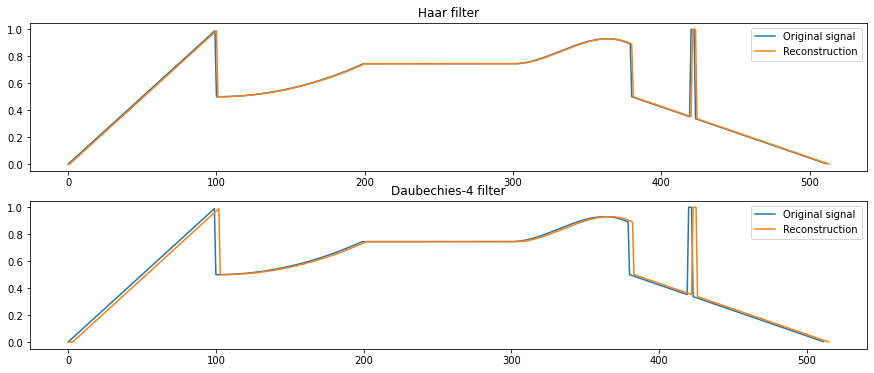

In [28]:
plt.figure(figsize=(15,6))
plt.subplot(2,1,1)
plt.plot(x)
plt.title("Haar filter")
plt.plot(y)
plt.legend(['Original signal', 'Reconstruction'])

plt.subplot(2,1,2)
plt.plot(x)
plt.title("Daubechies-4 filter")
plt.plot(y1)
plt.legend(['Original signal', 'Reconstruction'])
plt.show()

Comment on vanishing moments

In [29]:
error_haar = np.linalg.norm(x-y[1:-1])/np.linalg.norm(x)
error_daub = np.linalg.norm(x-y1[3:-1])/np.linalg.norm(x)
print('Relative error from reconstruction, Haar filter: ' + str(error_haar))

print('Relative error from reconstruction, Db4 filter: ' + str(error_daub))

Relative error from reconstruction, Haar filter: 1.2797703641191922e-12
Relative error from reconstruction, Db4 filter: 1.2770113573497566e-12


We can therefore conclude that perfect reconstruction was acheived

## 1.5

In the synthesis operation, the input signals were zero-padded with M-1 zeroes (M being the size of the filter h0). The resulting signal after the reconstruction has, therefore, size N+M, if N+M-1 is odd, or N+M-1, if N+M-1 is even (the added +1 appears because of the downsampling/upsampling). We can print their last M-1 coefficients to see if coefficient expansion occured.

In [30]:
print(y[-2:])
print(y1[-3:])

[0.00378788 0.        ]
[7.57575758e-03 3.78787879e-03 2.20396618e-15]


## 1.6

Nao sei

## 1.7

In [31]:
def MRA(x, h0, nLev):
    if nLev == 1:
        S = cqf_analysis_filterbank(x, h0)
        return S
    else:
        S = cqf_analysis_filterbank(x, h0)
        S =  MRA(S[0], h0, nLev-1) + [S[1]]
        return S

## 1.8

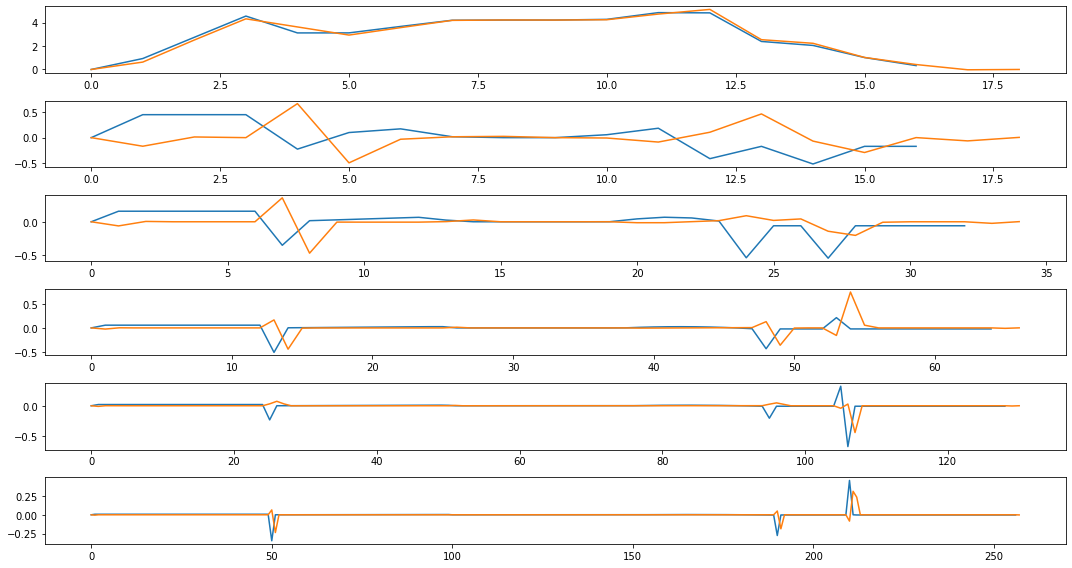

In [43]:
res_haar = MRA(x, h0_haar, 5)
res_db4 = MRA(x, h0_db4, 5)
plt.figure(figsize=(15,8))
#plt.subplots(5,2)
for i in range(0,len(res)):
    plt.subplot(len(res),1,i+1)
    plt.plot(res_haar[i])
    plt.plot(res_db4[i])
plt.tight_layout()
plt.show()

Comment about : the coefficient expansion ; the “spread” of the discontinuities along the levels ; the
parts of the signal that produce zero-valued coefficients at different resolution levels

## 1.9

## 1.10

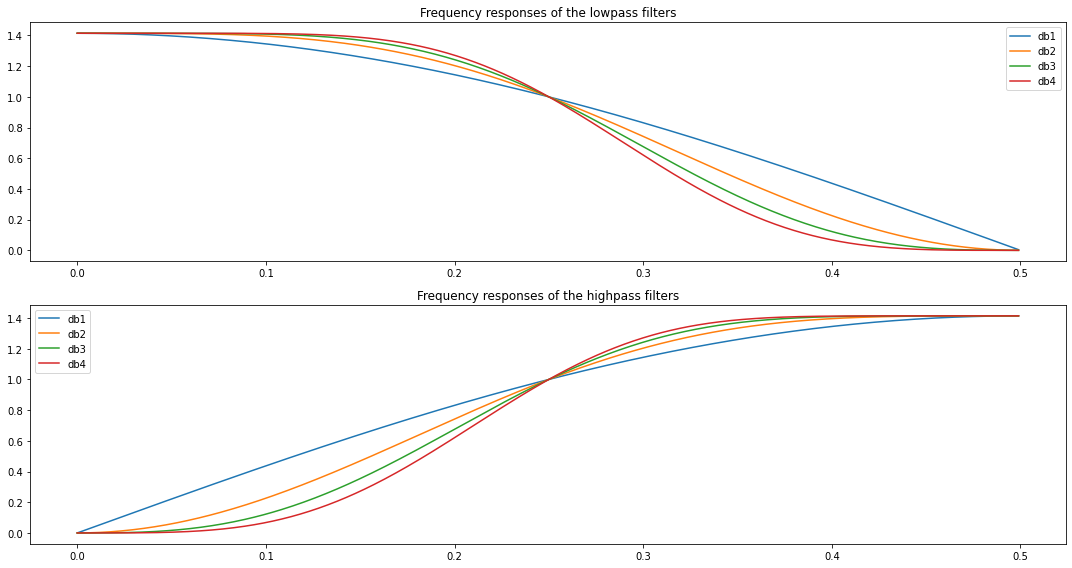

In [59]:
hdb = []
w = []
 
h_db1_lo = pywt.Wavelet('db1').dec_lo
h_db1_hi = pywt.Wavelet('db1').dec_hi
a, b = scipy.signal.freqz(h_db1_lo, fs=1)
w.append(a)
hdb.append(b)
a, b = scipy.signal.freqz(h_db1_hi, fs=1)
w.append(a)
hdb.append(b)

h_db2_lo = pywt.Wavelet('db2').dec_lo
h_db2_hi = pywt.Wavelet('db2').dec_hi
a, b = scipy.signal.freqz(h_db2_lo, fs=1)
w.append(a)
hdb.append(b)
a, b = scipy.signal.freqz(h_db2_hi, fs=1)
w.append(a)
hdb.append(b)

h_db3_lo = pywt.Wavelet('db3').dec_lo
h_db3_hi = pywt.Wavelet('db3').dec_hi
a, b = scipy.signal.freqz(h_db3_lo, fs=1)
w.append(a)
hdb.append(b)
a, b = scipy.signal.freqz(h_db3_hi, fs=1)
w.append(a)
hdb.append(b)

h_db4_lo = pywt.Wavelet('db4').dec_lo
h_db4_hi = pywt.Wavelet('db4').dec_hi
a, b = scipy.signal.freqz(h_db4_lo, fs=1)
w.append(a)
hdb.append(b)
a, b = scipy.signal.freqz(h_db4_hi, fs=1)
w.append(a)
hdb.append(b)

plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
for i in np.arange(0,len(hdb),2):
    plt.plot(w[i], abs(hdb[i]))
plt.legend(['db1', 'db2', 'db3', 'db4'])
plt.title('Frequency responses of the lowpass filters')
plt.subplot(2,1,2)
for i in np.arange(1,len(hdb),2):
    plt.plot(w[i], abs(hdb[i]))
plt.legend(['db1', 'db2', 'db3', 'db4'])
plt.title('Frequency responses of the highpass filters')

plt.tight_layout()
plt.show()

A visual conclusion can be drawn from the frequency responses of the lowpass and highpass filters for the Daubechies filterbanks with 1, 2, 3 and 5 vanishing moments: the higher the number of vanishing moments, the flatter the frequency response will be around the values of $\nu=0$ and $\nu=0,5$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import cv2
import pywt

## Exercise 2
### 2.1

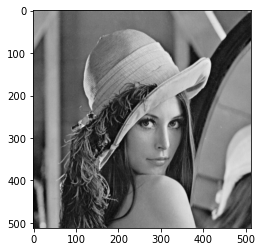

In [4]:
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
img = mpimg.imread('lena.jpg') 
plt.imshow(img) 
plt.set_cmap('gray')
plt.show()

### 2.2

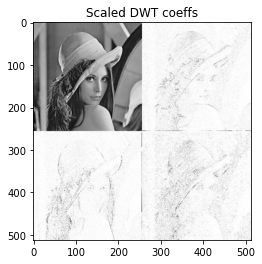

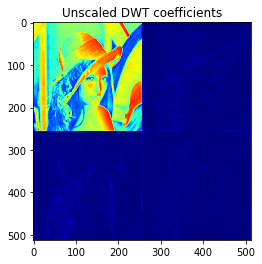

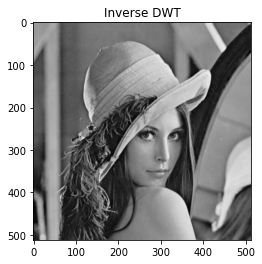

In [5]:
import wtt
wav = 'db3'
NLEV =1
filter_bank = pywt.Wavelet(wav)
coeffs = pywt.wavedec2(img, filter_bank, mode='per', level=NLEV) 
arr = wtt.coeffs_to_array(coeffs) #arrange them into an image
wtt.wtView(coeffs, 'Scaled DWT coeffs') 
plt.figure() 
plt.imshow(np.abs(arr/arr.max())) 
plt.set_cmap('jet')
plt.title('Unscaled DWT coefficients') 
plt.show()
decoded = pywt.waverec2(coeffs, filter_bank, mode='per') 
plt.imshow(np.uint8(decoded))
plt.title('Inverse DWT') 
plt.set_cmap('gray')
plt.show()

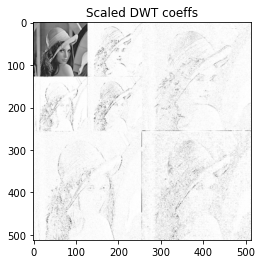

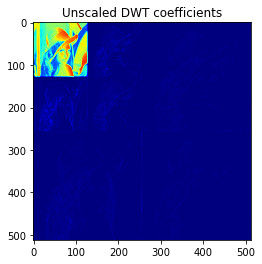

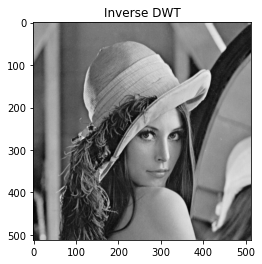

In [6]:
wav = 'db3'
NLEV =2
filter_bank = pywt.Wavelet(wav)
coeffs = pywt.wavedec2(img, filter_bank, mode='per', level=NLEV) 
arr2 = wtt.coeffs_to_array(coeffs) #arrange them into an image
wtt.wtView(coeffs, 'Scaled DWT coeffs') 
plt.figure() 
plt.imshow(np.abs(arr2/arr2.max())) 
plt.set_cmap('jet')
plt.title('Unscaled DWT coefficients') 
plt.show()
decoded = pywt.waverec2(coeffs, filter_bank, mode='per') 
plt.imshow(np.uint8(decoded))
plt.title('Inverse DWT') 
plt.set_cmap('gray')
plt.show()

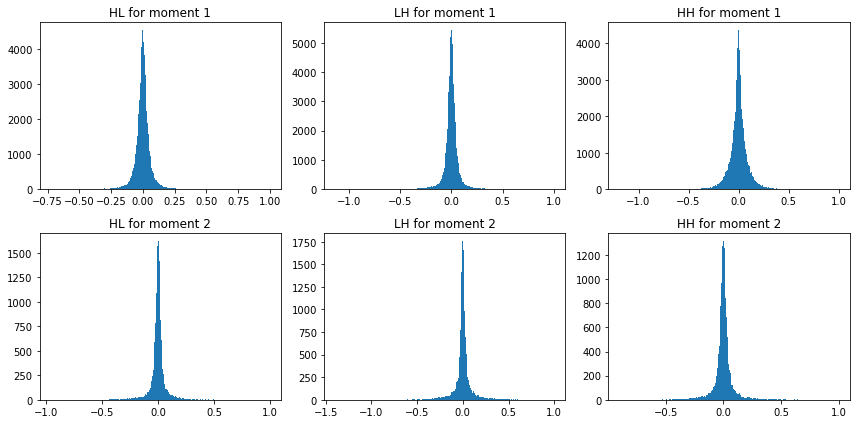

In [7]:
nbins=100
plt.subplots(2,3, figsize=(12, 6))

plt.subplot(231)
plt.hist(((arr[0:256, 256:512]/arr[0:256, 256:512].max()).ravel()), bins=300)
plt.title('HL for moment 1')

plt.subplot(232)
plt.hist((arr[256:512, 0:256]/arr[256:512, 0:256].max()).ravel(), bins=300)
plt.title('LH for moment 1')

plt.subplot(233)
plt.hist((arr[256:512, 256:512]/arr[256:512, 256:512].max()).ravel(), bins=300)
plt.title('HH for moment 1')


plt.subplot(234)
plt.hist((arr2[0:128, 128:256]/arr2[0:128, 128:256].max()).ravel(), bins=300)
plt.title('HL for moment 2')

plt.subplot(235)
plt.hist((arr2[128:256, 0:128]/arr2[128:256, 0:128].max()).ravel(), bins=300)
plt.title('LH for moment 2')

plt.subplot(236)
plt.hist((arr2[128:256, 128:256]/(arr2[128:256, 128:256]).max()).ravel(), bins=300)
plt.title('HH for moment 2')

plt.tight_layout()
plt.show()

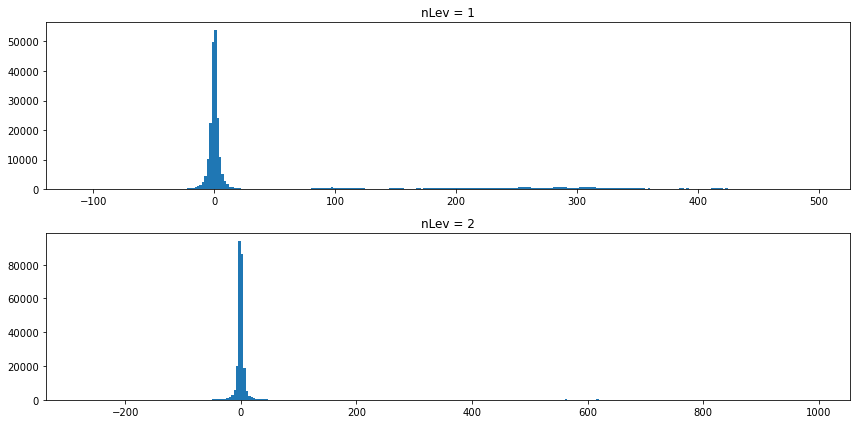

In [8]:
nbins=100
plt.subplots(2,1, figsize=(12, 6))

plt.subplot(211)
plt.hist(((arr).ravel()), bins=300)
plt.title('nLev = 1')

plt.subplot(212)
plt.hist((arr2).ravel(), bins=300)
plt.title('nLev = 2')

plt.tight_layout()
plt.show()

### 2.3

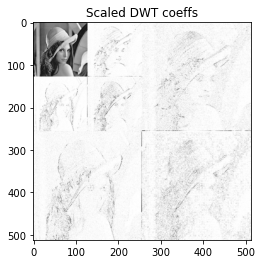

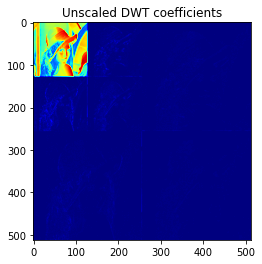

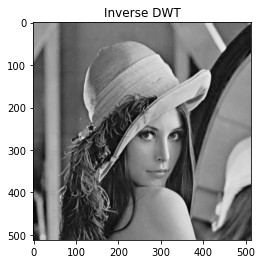

In [9]:
wav = 'bior4.4'
NLEV =2
filter_bank = pywt.Wavelet(wav)
coeffs = pywt.wavedec2(img, filter_bank, mode='per', level=NLEV) 

arr3 = wtt.coeffs_to_array(coeffs) #arrange them into an image
wtt.wtView(coeffs, 'Scaled DWT coeffs') 
plt.figure() 

plt.imshow(np.abs(arr3/arr3.max())) 
plt.set_cmap('jet')
plt.title('Unscaled DWT coefficients') 
plt.show()

decoded = pywt.waverec2(coeffs, filter_bank, mode='per') 
plt.imshow(np.uint8(decoded))
plt.title('Inverse DWT') 
plt.set_cmap('gray')
plt.show()

### 2.4

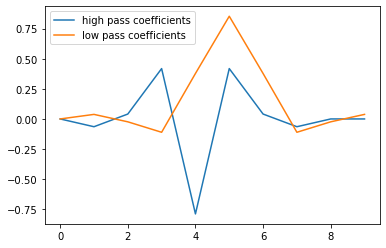

In [10]:
plt.plot(pywt.Wavelet('bior4.4').dec_hi, label='high pass coefficients')
plt.plot(pywt.Wavelet('bior4.4').dec_lo, label='low pass coefficients')
plt.legend()
plt.show()

### 2.5

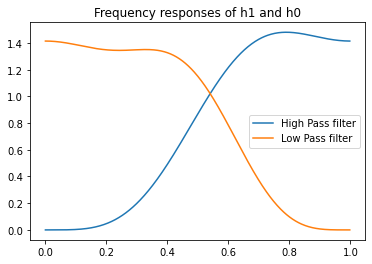

In [11]:
H0 = np.abs(sig.freqz(pywt.Wavelet('bior4.4').dec_hi)[1])
H1 = np.abs(sig.freqz(pywt.Wavelet('bior4.4').dec_lo)[1])
freq = sig.freqz(pywt.Wavelet('bior4.4').dec_hi)[0]/np.pi
plt.plot(freq, H0, label = 'High Pass filter')
plt.plot(freq, H1, label = 'Low Pass filter')
plt.legend()
plt.title('Frequency responses of h1 and h0')
plt.show()

### 2.6

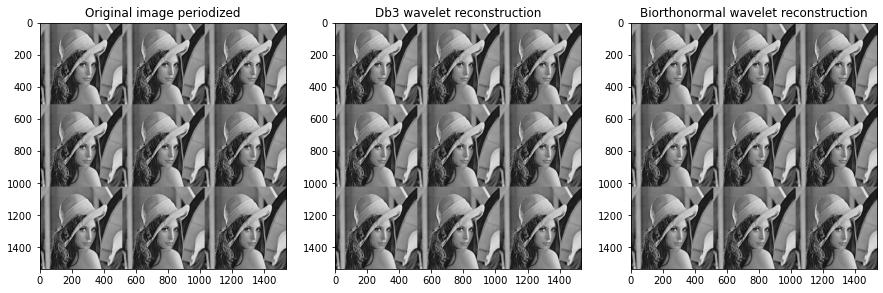

In [14]:
NLEV = 2
plt.subplots(1, 3, figsize=(15, 6))

plt.subplot(131)
conc = cv2.vconcat([img, cv2.vconcat([img, img])])
conc = cv2.hconcat([conc, cv2.hconcat([conc, conc])])
plt.title("Original image periodized")
plt.imshow(conc)

plt.subplot(132)
filter_bank = pywt.Wavelet('db3')
coeffs = pywt.wavedec2(conc, filter_bank, mode='per', level=NLEV)
db = pywt.waverec2(coeffs, filter_bank, mode='per')
plt.title("Db3 wavelet reconstruction")
plt.imshow(db)


plt.subplot(133)
filter_bank = pywt.Wavelet('bior4.4')
coeffs = pywt.wavedec2(conc, filter_bank, mode='per', level=NLEV)
bior = pywt.waverec2(coeffs, filter_bank, mode='per')
plt.title("Biorthonormal wavelet reconstruction")
plt.imshow(bior)

plt.show()

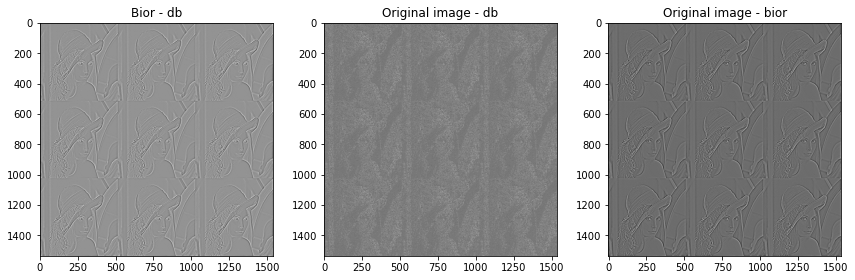

In [15]:

img1=conc
filter_bank = pywt.Wavelet('bior4.4')
coeffs = pywt.wavedec2(img, filter_bank, mode='per', level=NLEV)
bior1 = pywt.waverec2(coeffs, filter_bank, mode='per')

filter_bank = pywt.Wavelet('db3')
coeffs = pywt.wavedec2(img, filter_bank, mode='per', level=NLEV)
db1 = pywt.waverec2(coeffs, filter_bank, mode='per')
plt.subplots(1,3, figsize = (12,12))

plt.subplot(131)
plt.imshow(bior-db)
plt.title('Bior - db')

plt.subplot(132)
plt.imshow(conc-db)
plt.title('Original image - db')

plt.subplot(133)
plt.imshow(conc-bior)
plt.title('Original image - bior')

plt.tight_layout()
plt.show()



We tried to periodize the original image to then reconstruct them and observe the borders, however there were no noticeable changes on the borders. To try to visualize something we then tried to subtract the images from the original to see the differences. However there was nothing really interesting to be observed